## 0. 모듈 임포트 
-----

In [1]:
import cv2
import numpy as np
import os
import tarfile
import urllib

from matplotlib import pyplot as plt
import tensorflow as tf

## 1. 인물모드 직접해보기
-----

## 1-1. 내 셀카 인물모드 사진 3 장 만들기
-----

### 이미지 불러오기

In [73]:
dir_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/'
img_paths = os.listdir(dir_path)
img_origs = []

for file_path in img_paths:
    if os.path.isfile(dir_path+file_path) and file_path[:-5] == 'my_face':
        img_origs.append(cv2.imread(dir_path+file_path))
        
for img_orig in img_origs:
    print(img_orig.shape)

(4032, 1816, 3)
(2203, 1816, 3)
(3072, 1383, 3)


### Shallow focus 만들기

#### DeepLab 모델

In [9]:
class DeepLabModel(object):
    INPUT_TENSOR_NAME = 'ImageTensor:0'
    OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
    INPUT_SIZE = 513
    FROZEN_GRAPH_NAME = 'frozen_inference_graph'

    # __init__()에서 모델 구조를 직접 구현하는 대신, tar file에서 읽어들인 그래프구조 graph_def를 
    # tf.compat.v1.import_graph_def를 통해 불러들여 활용하게 됩니다. 
    def __init__(self, tarball_path):
        self.graph = tf.Graph()
        graph_def = None
        tar_file = tarfile.open(tarball_path)
        for tar_info in tar_file.getmembers():
            if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
                file_handle = tar_file.extractfile(tar_info)
                graph_def = tf.compat.v1.GraphDef.FromString(file_handle.read())
                break
        tar_file.close()

        with self.graph.as_default():
    	    tf.compat.v1.import_graph_def(graph_def, name='')

        self.sess = tf.compat.v1.Session(graph=self.graph)

    # 이미지를 전처리하여 Tensorflow 입력으로 사용 가능한 shape의 Numpy Array로 변환합니다.
    def preprocess(self, img_orig):
        height, width = img_orig.shape[:2]
        resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
        target_size = (int(resize_ratio * width), int(resize_ratio * height))
        resized_image = cv2.resize(img_orig, target_size)
        resized_rgb = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)
        img_input = resized_rgb
        return img_input
        
    def run(self, image):
        img_input = self.preprocess(image)

        # Tensorflow V1에서는 model(input) 방식이 아니라 sess.run(feed_dict={input...}) 방식을 활용합니다.
        batch_seg_map = self.sess.run(
            self.OUTPUT_TENSOR_NAME,
            feed_dict={self.INPUT_TENSOR_NAME: [img_input]})

        seg_map = batch_seg_map[0]
        return cv2.cvtColor(img_input, cv2.COLOR_RGB2BGR), seg_map

#### 사전 학습된 가중치 가져오기 

In [41]:
# define model and download & load pretrained weight
_DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'

model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
tf.io.gfile.makedirs(model_dir)

print ('temp directory:', model_dir)

download_path = os.path.join(model_dir, 'deeplab_model.tar.gz')
if not os.path.exists(download_path):
    urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + 'deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz',
                   download_path)

MODEL = DeepLabModel(download_path)
print('model loaded successfully!')

temp directory: /aiffel/aiffel/human_segmentation/models
model loaded successfully!


#### 준비한 이미지를 네트워크에 입력

In [64]:
img_resizeds = [] # resize된 img들의 리스트
for img_orig in img_origs:
    img_resized, seg_map = MODEL.run(img_orig)
    print (img_orig.shape, img_resized.shape, seg_map.max())
    img_resizeds.append((img_resized, seg_map))

(4032, 1816, 3) (513, 231, 3) 15
(2203, 1816, 3) (513, 422, 3) 15
(3072, 1383, 3) (513, 230, 3) 15


### person 라벨을 적용한 세그멘테이션 마스크 만들기

####  PASCAL VOC 데이터셋 에서 person 라벨의 인덱스 확인

In [43]:
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
LABEL_NAMES.index('person')

15

#### 세그멘테이션 마스크 만들기

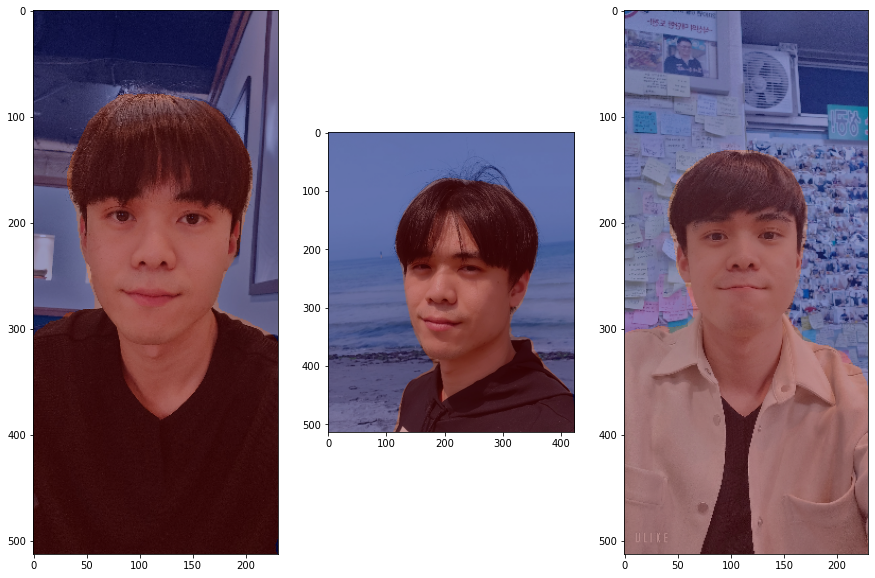

In [105]:
img_masks = []  # img_mask들의 리스트

fig, axes = plt.subplots(1,3, figsize=(15, 10))
ax = axes.flatten()

for idx, img_resized in enumerate(img_resizeds):
    img_show = img_resized[0].copy()
    seg_map = np.where(img_resized[1] == 15, 15, 0) # 예측 중 사람만 추출
    img_mask = img_resized[1] * (255/img_resized[1].max())
    img_mask = img_mask.astype(np.uint8)
    img_masks.append(img_mask)
    color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
    img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)
    ax[idx].imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
 
plt.show()

### 세그멘테이션 마스크 원래 크기로 복원

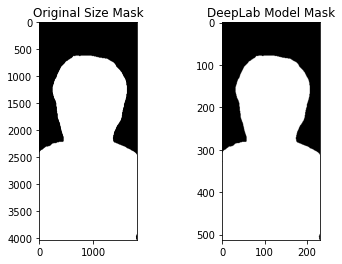

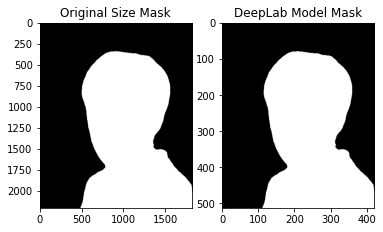

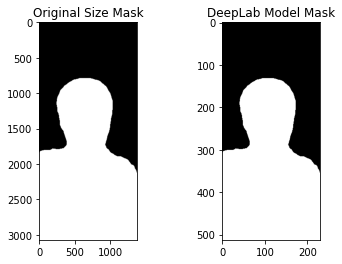

In [122]:
img_mask_ups = [] # 원본 크기 img_mask들의 리스트

for orig_mask in zip(img_origs, img_masks): # 3개 이미지의 원본 사이즈 마스크와 DeepLab 모델 마스크 비교 
    img_mask_up = cv2.resize(orig_mask[1], orig_mask[0].shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
    _, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)
    img_mask_ups.append(img_mask_up)
    
    ax = plt.subplot(1,2,1)
    plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
    ax.set_title('Original Size Mask')

    ax = plt.subplot(1,2,2)
    plt.imshow(orig_mask[1], cmap=plt.cm.binary_r)
    ax.set_title('DeepLab Model Mask')

    plt.show()

### 배경 블러처리

#### 원본이미지 블러처리

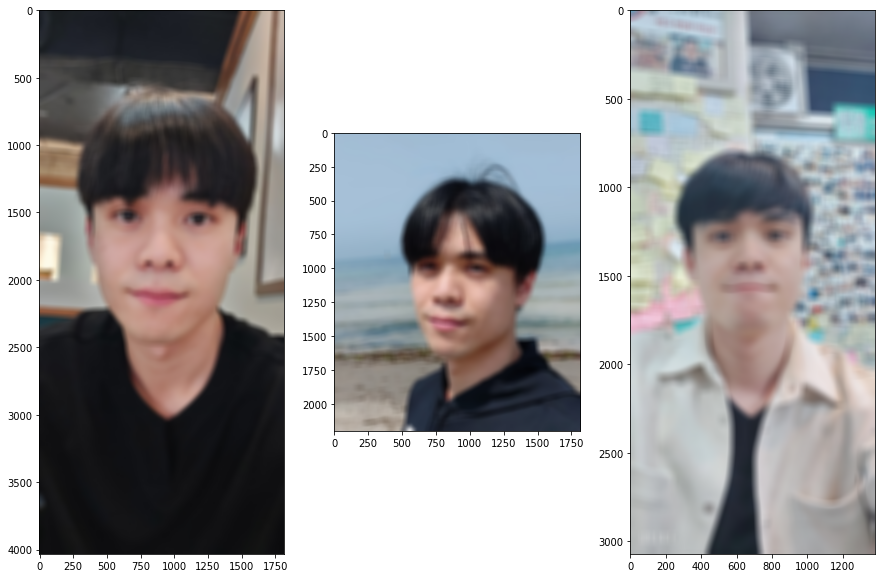

In [103]:
img_orig_blurs = [] # img_orig_blur들의 리스트

fig, axes = plt.subplots(1,3, figsize=(15, 10))
ax = axes.flatten()

for idx, img_orig in enumerate(img_origs): # 3개 이미지 모두 블러처리
    img_orig_blur = cv2.blur(img_orig, (50,50)) 
    img_orig_blurs.append(img_orig_blur)
    ax[idx].imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
    
plt.show()

#### 세그멘테이션 마스크를 이용한 배경 추출 

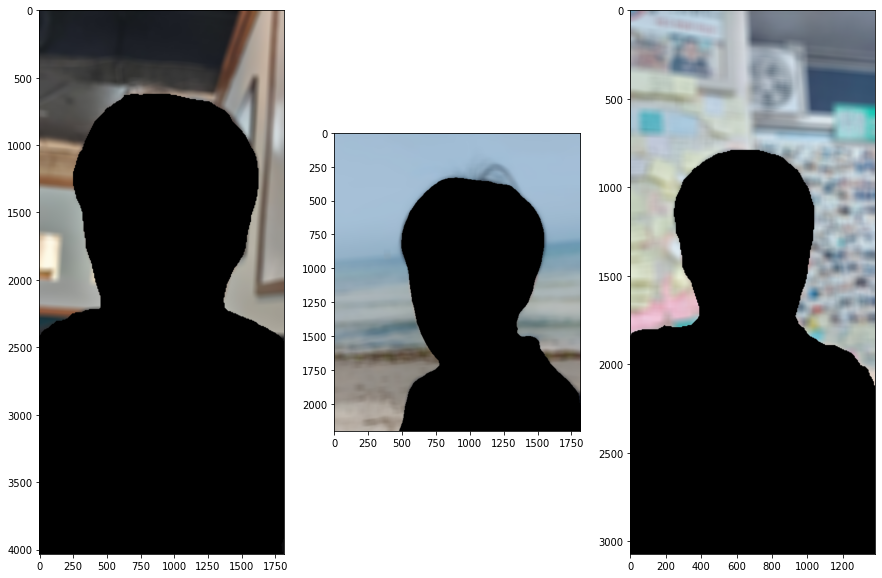

In [104]:
img_bg_blurs, img_mask_colors = [], [] # img_bg_blur와 img_mask_color의 리스트

fig, axes = plt.subplots(1,3, figsize=(15, 10))
ax = axes.flatten()


for idx, blur_maskup in enumerate(zip(img_orig_blurs, img_mask_ups)): # 3개 이미지의 배경 추출
    img_mask_color = cv2.cvtColor(blur_maskup[1], cv2.COLOR_GRAY2BGR)
    img_mask_colors.append(img_mask_color) 
    img_bg_mask = cv2.bitwise_not(img_mask_color)
    img_bg_blur = cv2.bitwise_and(blur_maskup[0], img_bg_mask)
    img_bg_blurs.append(img_bg_blur)
    ax[idx].imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))

plt.show()

### 블러 처리된 배경과 원본의 사람 이미지 합치기 

(4032, 1816, 3) (4032, 1816, 3)
(4032, 1816, 3) (2203, 1816, 3)
(4032, 1816, 3) (3072, 1383, 3)


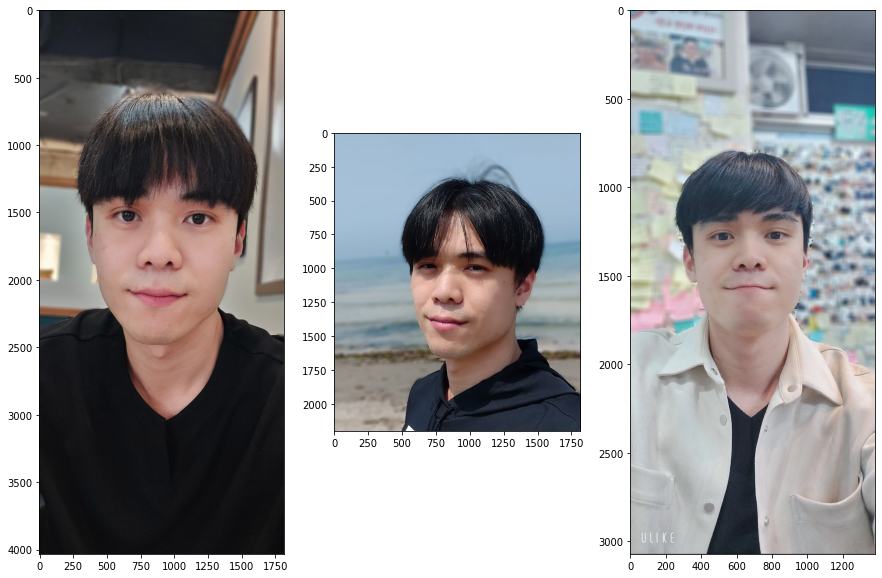

In [102]:
img_concats = [] # img_concat의 리스트

fig, axes = plt.subplots(1,3, figsize=(15, 10))
ax = axes.flatten()

for idx, orig_bgblur_color in enumerate(zip(img_origs, img_bg_blurs, img_mask_colors)): # 3개 이미지의 블러 처리된 배경과 원본 이미지 합성 
    print(orig_bgblur[0].shape, orig_bgblur_color[1].shape)
    img_concat = np.where(orig_bgblur_color[2]==255, orig_bgblur_color[0], orig_bgblur_color[1])
    img_concats.append(img_concat)
    ax[idx].imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))

plt.show()

## 1-2 고양이 아웃포커싱 사진
-----

### 이미지 불러오기

In [111]:
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/cat.jpg' 
img_orig = cv2.imread(img_path) 
print (img_orig.shape)

(340, 509, 3)


### Shallow focus 만들기

#### 준비한 이미지를 네트워크에 입력

In [23]:
img_resized, seg_map = MODEL.run(img_orig)
print (img_orig.shape, img_resized.shape, seg_map.max())

(340, 509, 3) (342, 513, 3) 8


#### cat 라벨의 인덱스 확인

In [27]:
LABEL_NAMES.index('cat')

8

#### 세그멘테이션 마스크 만들기

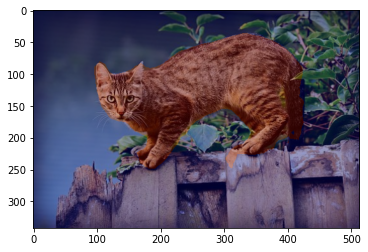

In [28]:
img_show = img_resized.copy()
seg_map = np.where(seg_map == 8, 8, 0) 
img_mask = seg_map * (255/seg_map.max()) 
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

### 세그멘테이션 마스크 원래크기로 복원

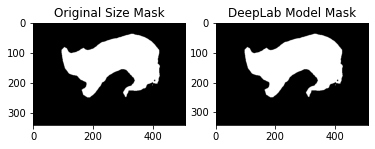

In [29]:
img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

### 배경 블러처리

#### 원본이미지 블러처리

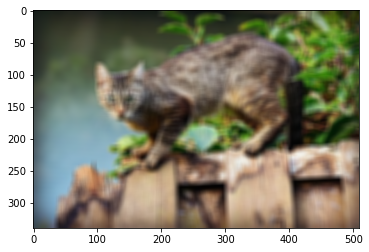

In [33]:
img_orig_blur = cv2.blur(img_orig, (10,10)) 
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

#### 세그멘테이션 마스크를 이용한 배경 추출 

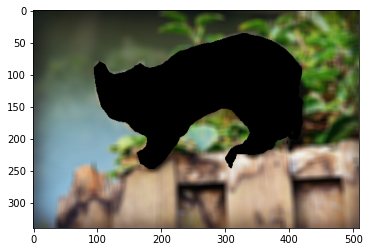

In [34]:
img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

### 블러 처리된 배경과 원본의 고양이 이미지 합치기 

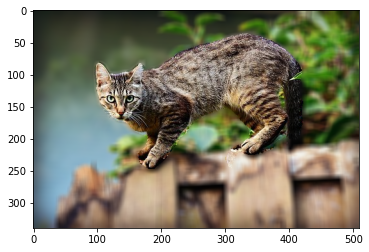

In [35]:
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

## 1-3. 크로마키 배경 with 고양이
-----

### 이미지 불러오기

In [112]:
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/cat.jpg'  
img_orig = cv2.imread(img_path) 
print (img_orig.shape)

(340, 509, 3)


#### 크로마키 배경

In [120]:
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/space.jpg'  
img_chroma = cv2.imread(img_path) 
print (img_chroma.shape)

(601, 1068, 3)


### Shallow focus 만들기

#### 주어진 이미지 네트워크에 입력

In [113]:
img_resized, seg_map = MODEL.run(img_orig)
print (img_orig.shape, img_resized.shape, seg_map.max())

(340, 509, 3) (342, 513, 3) 8


#### cat의 라벨인덱스 확인

In [114]:
LABEL_NAMES.index('cat')

8

#### 세그멘테이션 마스크 만들기

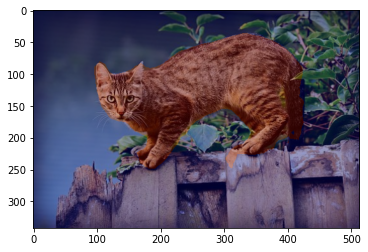

In [115]:
img_show = img_resized.copy()
seg_map = np.where(seg_map == 8, 8, 0) 
img_mask = seg_map * (255/seg_map.max()) 
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

### 세그멘테이션 마스크 원래크기로 복원

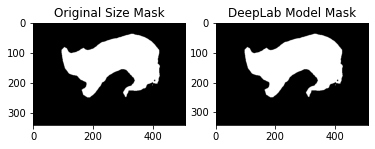

In [125]:
img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

### 세그멘테이션 마스크를 활용하여 합성될 배경 추출

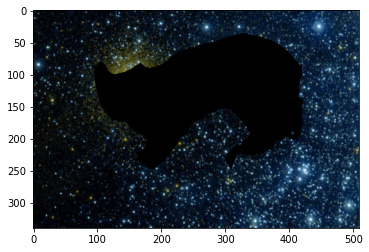

In [127]:
img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
resized_chroma = cv2.resize(img_chroma, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR) # 합성될 배경의 크기를 원본이미지와 같게 resize 
img_bg_chroma = cv2.bitwise_and(resized_chroma, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_chroma, cv2.COLOR_BGR2RGB))
plt.show()

### 추출된 배경과 고양이 이미지 합성하기

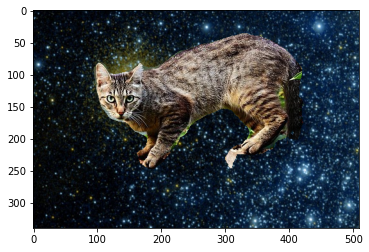

In [128]:
img_concat = np.where(img_mask_color==255, img_orig, img_bg_chroma)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

## 2. 인물모드의 문제점 찾기
-----

### 피사체 주변의 배경 일부가 피사체의 라벨 영역으로 함께 인식되는 문제

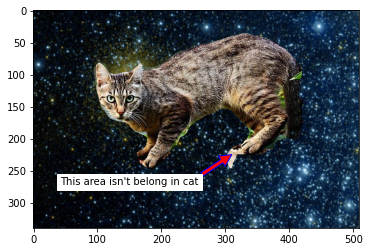

In [173]:
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
# 화살표 및 텍스트 추가
plt.annotate('This area isn\'t belong in cat', fontsize=10,
bbox=dict(boxstyle='square', color='white'),            
ha = 'center', va = 'bottom', 
xytext = (150, 275), 
xy = (310, 225), 
arrowprops = {'facecolor' : 'r', 
              'edgecolor':'b', 
              'shrink' : 10.0, 
              'alpha':1.0 
              })
plt.show()

> 배경을 블러처리 할 때는 거슬리지 않는 수준의 문제이지만   
**사진을 다른 배경에 합성할 때는 매우 부자연스럽게 인식된다.**

## 3. 문제 해결하기
-----

### 문제의 핵심: 깊이(Depth)

> 광학 카메라에서 아웃 포커싱은 **피사체들 간의 상대적인 거리차이**에 의해 상이 맺히는 지점에서 응집되는 광량에 차이가 생겨 발생한다.  
  하지만 이번 노드에서 세그멘테이션 마스크를 생성할 때는 물체 간의 거리 차이가 고려되지 않았다. 

#### computaionl 카메라에서도 광학카메라와 같은 세밀한 피사체별 거리 구분이 가능해야만 이 문제를 해결할 수 있다.  

이 문제를 해결하기 위한 3D Depth Camera, Struct2Depth, uDepth 와 같은 기법들이 있다.



## 4. 후기
-----

이번 노드에서는 얼굴모드의 문제점에 대한 개선책을 수립하는데 사용하는 참고자료의 난이도가 매우 높았던 점이 어려웠다.

다른 두 개의 평가지표는 고민으로 풀어냈지만, 세 번째 지표를 충족하는 부분은 막막하게 다가왔다. 

피사체 간의 거리 차이를 인식하기 위한 딥러닝 네트워크의 설계에 대한 내용을 해결책을 제시할 수 있을 정도로는 이해할 수 없어서 세 번째 지표는 다 완수해내지 못했다.

내가 부족했던 부분은 딥러닝 네트워크에 대한 이해 그리고 언어의 장벽이었다.

특히 Struct2Depth와 uDepth에 관한 내용을 볼 때 한글로 잘 번역된 문서가 있었으면하는 생각이 많이 들었다.

주말에 시간을 들여서 블로그에 번역본을 포스팅 해보고 공유해서 검증 및 수정을 거쳐보면 좋은 공부가 될 것 같다.